In [1]:
import os

import pandas as pd
import yaml

from src import train


data_name = "FreeSolv"


config_filepath = os.path.join("configs", f"{data_name}.yaml")
with open(config_filepath) as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

filepath = config["dataset"]["filepath"]
prop = config["dataset"]["prop"]
bayopt_bounds = config["bayopt_bounds"]

data = pd.read_csv(filepath)
data = data[["smiles", prop]]
data.shape

(642, 2)

***Sampling and splitting of the dataset.***

['pad', 'unk', '-', 'c', '5', '1', 'F', ' ', '[S+2]', 'N', ')', '=', '[C@H]', 'C', '#', 'P', '2', 'n', 's', 'O', '\\', '4', '(', 'Cl', '[nH]', '/', 'I', '[C@@H]', '[C@]', '3', '[C@@]', '[O-]', 'Br', 'S', '[N+]']


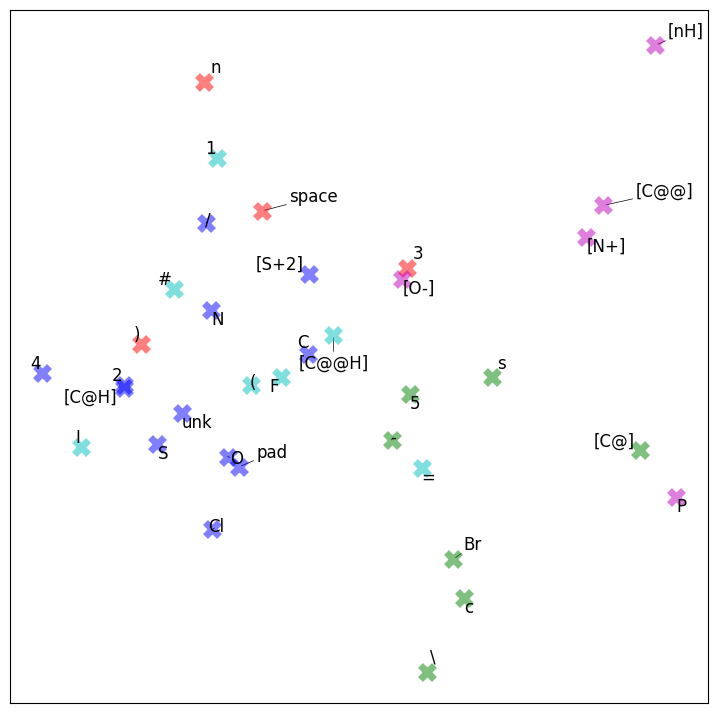

In [33]:
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import yaml
import torch
from adjustText import adjust_text
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation

from src import utils
from src.features import token, augm
from src.models.LSTMAttention import LSTMAttention

test_dir = "FreeSolv"

print("***Sampling and splitting of the dataset.***\n")
augmentation = True
poly_flag = False
affinity_propn = True
# Reproducing the data split of the requested fold (k_fold_index)
smiles_train, smiles_valid, smiles_test, y_train, y_valid, y_test, scaler = (
    utils.random_split(
        smiles_input=np.array(data.iloc[:, 0]),
        y_input=np.array(data.iloc[:, 1]),
        random_state=config["train"]["seed"],
        scaling=True
    )
)

smiles_train, enum_card_train, y_train = augm.augment_data(
    smiles_train, y_train, augmentation
)
tokenized_smiles_train = token.get_tokens(smiles_train, poly_flag=poly_flag)
smiles_valid, enum_card_valid, y_valid = augm.augment_data(
    smiles_valid, y_valid, augmentation
)
tokenized_smiles_valid = token.get_tokens(smiles_valid, poly_flag=poly_flag)
smiles_test, enum_card_test, y_test = augm.augment_data(
    smiles_test, y_test, augmentation
)
tokenized_smiles_test = token.get_tokens(smiles_test, poly_flag=poly_flag)
all_smiles_tokens = tokenized_smiles_train + tokenized_smiles_valid + tokenized_smiles_test
tokens = list(token.extract_vocab(all_smiles_tokens))
vocab_size = len(tokens)
tokens, vocab_size = token.add_extra_tokens(tokens, vocab_size)
max_length = np.max([len(i_smiles) for i_smiles in all_smiles_tokens])
max_length = max_length + 1
token_to_int = token.get_tokentoint(tokens)
int_to_token = token.get_inttotoken(tokens)
print(tokens)
tokens_train, y_train = token.convert_to_int_tensor(
    tokenized_smiles_train, y_train, max_length, tokens
)
tokens_valid, y_valid = token.convert_to_int_tensor(
    tokenized_smiles_valid, y_train, max_length, tokens
)
tokens_test, y_test = token.convert_to_int_tensor(
    tokenized_smiles_test, y_train, max_length, tokens
)
train_unique_tokens = token.extract_vocab(tokens_train)
valid_unique_tokens = token.extract_vocab(tokens_valid)
test_unique_tokens = token.extract_vocab(tokens_test)

params = yaml.load(open(f"reports/{data_name}/model/all_params.yaml"), Loader=yaml.FullLoader)
model = LSTMAttention(
    **params["hyper_parameters"]["model"],
)

model.load_state_dict(torch.load(f"reports/{data_name}/model/best_weights.pth", map_location=torch.device("cpu")))
model_embed_weights = model.state_dict()["embedding_layer.weight"]
pca = PCA(n_components=2, random_state=config["train"]["seed"])
transformed_weights = pca.fit_transform(model_embed_weights)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot()
ax.set_aspect(aspect="equal", adjustable="box")

if affinity_propn:
    af = AffinityPropagation().fit(model_embed_weights)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    n_clusters = len(cluster_centers_indices)
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters), colors):
        class_members = np.where(np.array(labels == k) == True)[0].tolist()
        for ilabpt in class_members:
            alpha_tmp = 0.5 if tokens[ilabpt] in train_unique_tokens else 0.5
            line_tmp = 1 if tokens[ilabpt] in train_unique_tokens else 5
            marker_tmp = 'o' if tokens[ilabpt] in train_unique_tokens else 'x'
            edge_color_tmp = 'black' if tokens[ilabpt] in train_unique_tokens else col
            ax.plot(transformed_weights[ilabpt, 0],
                    transformed_weights[ilabpt, 1], col,
                    marker=marker_tmp, markeredgecolor = edge_color_tmp, markeredgewidth=line_tmp,
                    alpha=alpha_tmp, markersize=10)
else:
    # Black and white plot
    for ilabpt in range(vocab_size):
        alpha_tmp = 0.5 if tokens[ilabpt] in train_unique_tokens else 0.2
        size_tmp = 40 if tokens[ilabpt] in train_unique_tokens else 20
        ax.scatter(transformed_weights[ilabpt,0], transformed_weights[ilabpt,1],
                    lw=1, s=size_tmp, facecolor='black', marker='o', alpha=alpha_tmp)
annotations = []
weight_tmp = 'bold'
ilabpt = 0
for ilabpt, (x_i, y_i) in enumerate(zip(transformed_weights[:,0].tolist(),
                                        transformed_weights[:,1].tolist())):
    weight_tmp = 'black' if tokens[ilabpt] in train_unique_tokens else 'normal'
    tokens_tmp = tokens[ilabpt]
    if tokens_tmp == ' ':
        tokens_tmp = 'space'
    elif tokens_tmp == '.':
        tokens_tmp = 'dot'
    annotations.append(plt.text(x_i,y_i, tokens_tmp, fontsize=12, weight=weight_tmp))
adjust_text(annotations,
            x=transformed_weights[:,0].tolist(),y=transformed_weights[:,1].tolist(),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.xticks([])
plt.yticks([])
ax.axis('tight')

# plt.savefig(save_dir+'Visualization_'+data_name+'_Embedding_fold_'+str(k_fold_index)+'.png', bbox_inches='tight')
plt.show()

In [34]:
import math

from rdkit.Chem import Draw

def GetSimilarityMapFromWeights(mol, weights, colorMap=None, scale=-1, size=(250, 250),
                                sigma=None, coordScale=1.5, step=0.01, colors='k', contourLines=10,
                                alpha=0.5, **kwargs):
    """
    Generates the similarity map for a molecule given the atomic weights.
    Parameters:
    mol -- the molecule of interest
    colorMap -- the matplotlib color map scheme, default is custom PiWG color map
    scale -- the scaling: scale < 0 -> the absolute maximum weight is used as maximum scale
                          scale = double -> this is the maximum scale
    size -- the size of the figure
    sigma -- the sigma for the Gaussians
    coordScale -- scaling factor for the coordinates
    step -- the step for calcAtomGaussian
    colors -- color of the contour lines
    contourLines -- if integer number N: N contour lines are drawn
                    if list(numbers): contour lines at these numbers are drawn
    alpha -- the alpha blending value for the contour lines
    kwargs -- additional arguments for drawing
    """
    if mol.GetNumAtoms() < 2:
        raise ValueError("too few atoms")
    fig = Draw.MolToMPL(mol, coordScale=coordScale, size=size, **kwargs)
    if sigma is None:
        if mol.GetNumBonds() > 0:
            bond = mol.GetBondWithIdx(0)
            idx1 = bond.GetBeginAtomIdx()
            idx2 = bond.GetEndAtomIdx()
            sigma = 0.3 * math.sqrt(
                    sum([(mol._atomPs[idx1][i] - mol._atomPs[idx2][i])**2 for i in range(2)]))
        else:
            sigma = 0.3 * math.sqrt(sum([(mol._atomPs[0][i] - mol._atomPs[1][i])**2 for i in range(2)]))
        sigma = round(sigma, 2)
    x, y, z = Draw.calcAtomGaussians(mol, sigma, weights=weights, step=step)
    # scaling
    if scale <= 0.0:
        maxScale = max(math.fabs(np.min(z)), math.fabs(np.max(z)))
        minScale = min(math.fabs(np.min(z)), math.fabs(np.max(z)))
    else:
        maxScale = scale

    fig.axes[0].imshow(z, cmap=colorMap, interpolation='bilinear', origin='lower',
                     extent=(0, 1, 0, 1), vmin=minScale, vmax=maxScale)
    # contour lines
    # only draw them when at least one weight is not zero
    if len([w for w in weights if w != 0.0]):
        contourset = fig.axes[0].contour(x, y, z, contourLines, colors=colors, alpha=alpha, **kwargs)
        for j, c in enumerate(contourset.collections):
            if contourset.levels[j] == 0.0:
                c.set_linewidth(0.0)
            elif contourset.levels[j] < 0:
                c.set_dashes([(0, (3.0, 3.0))])
    fig.axes[0].set_axis_off()
    return fig

['pad', 'unk', '#', '[C@]', 'O', '[O-]', '[C@H]', 'Br', '\\', '2', 'S', ' ', '[C@@H]', '[C@@]', 'F', 'n', '[N+]', 's', '4', ')', 'c', '=', '/', 'C', '[S+2]', '-', '5', 'I', 'Cl', '1', 'N', 'P', '(', '3', '[nH]']
35
51
torch.Size([18, 51])


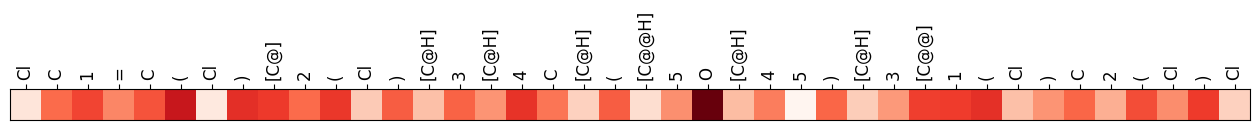

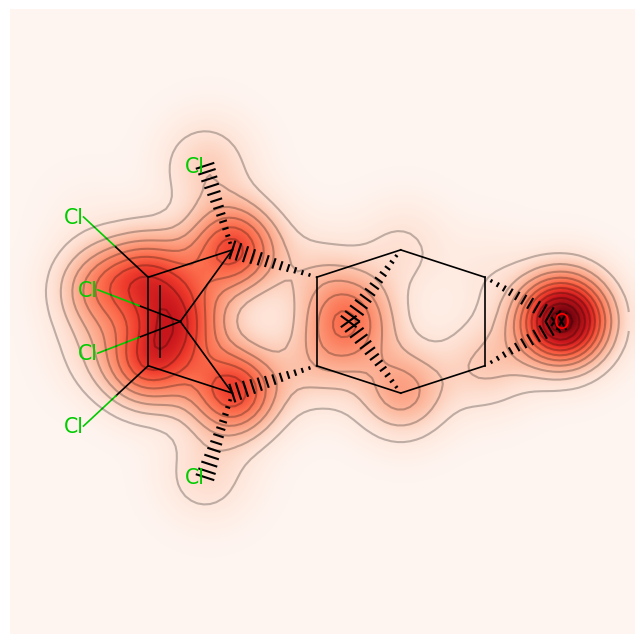

In [35]:
from rdkit import Chem
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler


smiles_toviz = (
    "ClC1=C(Cl)[C@]2(Cl)[C@H]3[C@H]4C[C@H]([C@@H]5O[C@@H]54)[C@H]3[C@@]1(Cl)C2(Cl)Cl"
)
params = yaml.load(
    open(f"reports/{data_name}/model/all_params.yaml"), Loader=yaml.FullLoader
)



mol_toviz = Chem.MolFromSmiles(smiles_toviz)
if mol_toviz != None:
    smiles_toviz_can = Chem.MolToSmiles(mol_toviz)
else:
    print("***Process of visualization automatically aborted!***")
    print("The smiles_toviz is incorrect and cannot be canonicalized by RDKit.")
smiles_toviz_x = np.array([smiles_toviz_can])
if smiles_toviz_can in np.array(data.smiles):
    smiles_toviz_y = np.array(
        [[data.iloc[np.where(data.smiles == smiles_toviz_x[0])[0][0], 1]]]
    )
else:
    smiles_toviz_y = np.array([[np.nan]])


enum_smiles_toviz_x, enum_card_toviz, enum_smiles_toviz_y = augm.augment_data(
    smiles_toviz_x, smiles_toviz_y, augmentation
)
enum_smiles_toviz_x = token.get_tokens(enum_smiles_toviz_x, poly_flag=poly_flag)

tokens = params["token"]["vocabulary"]
vocab_size = len(tokens)
print(tokens)
print(vocab_size)
# tokens, vocab_size = token.add_extra_tokens(tokens, vocab_size)
max_length = params["token"]["max_length"]
print(max_length)
token_to_int = token.get_tokentoint(tokens)
int_to_token = token.get_inttotoken(tokens)


tokens_toviz, y_toviz = token.convert_to_int_tensor(
    enum_smiles_toviz_x, enum_smiles_toviz_y, max_length, tokens
)
print(tokens_toviz.shape)


model = LSTMAttention(
    **params["hyper_parameters"]["model"],
)
model.load_state_dict(
    torch.load(
        f"reports/{data_name}/model/best_weights.pth", map_location=torch.device("cpu")
    )
)

def store_feature(module, input, output):
    global intermediate_output
    intermediate_output = output
model.timedistributed_dense_layer.register_forward_hook(store_feature)

model.eval()
with torch.no_grad():
    output = model(tokens_toviz)
intermediate_output_cumsum = np.cumsum(enum_card_toviz)
enum_card_toviz_shift = shift(intermediate_output_cumsum, 1, cval=0)
mols_id = 0

ienumcard = enum_card_toviz_shift[mols_id]

smiles_len_tmp = len(enum_smiles_toviz_x[ienumcard])
# smiles_len_tmp = max_length
intermediate_output_tmp = (
    intermediate_output.detach()
    .numpy()[ienumcard, -smiles_len_tmp + 1 : -1]
    .mean(axis=1)
    .reshape(1, -1)
)
max_intermediate_output_tmp = np.max(intermediate_output_tmp)


plt.matshow(intermediate_output_tmp, cmap="Reds")
plt.tick_params(axis="x", bottom=False)
plt.xticks([ix for ix in range(smiles_len_tmp - 2)])
plt.xticks(
    range(smiles_len_tmp - 2),
    [
        int_to_token[iint].replace("pad", "")
        for iint in tokens_toviz.detach().numpy()[ienumcard, -smiles_len_tmp + 1 : -1]
    ],
    fontsize=12,
    rotation="vertical",
)
plt.yticks([])
plt.show()

tokens_toviz = tokens_toviz.detach().numpy()

smiles_tmp = "".join(enum_smiles_toviz_x[ienumcard])
mol_tmp = Chem.MolFromSmiles(smiles_tmp)
smiles_len_tmp = len(enum_smiles_toviz_x[ienumcard])
mol_df_tmp = pd.DataFrame(
    [
        enum_smiles_toviz_x[ienumcard][1:-1],
        intermediate_output[ienumcard].mean(axis=1).tolist()[-smiles_len_tmp + 1 : -1],
    ]
).transpose()
bond = ["-", "=", "#", "$", "/", "\\", ".", "(", ")"]
mol_df_tmp = mol_df_tmp[~mol_df_tmp.iloc[:, 0].isin(bond)]
mol_df_tmp = mol_df_tmp[
    [not itoken.isdigit() for itoken in mol_df_tmp.iloc[:, 0].values.tolist()]
]

minmaxscaler = MinMaxScaler(feature_range=(0, 1))
norm_weights = (
    minmaxscaler.fit_transform(mol_df_tmp.iloc[:, 1].values.reshape(-1, 1))
    .flatten()
    .tolist()
)
fig = GetSimilarityMapFromWeights(
    mol=mol_tmp,
    size=(250, 250),
    scale=-1,
    sigma=0.05,
    weights=norm_weights,
    colorMap="Reds",
    contourLines=10,
    alpha=0.25,
)
fig.show()
